

## Diffusion-FS: Interpretable Diffusion and Progressive Distillation forTime Series Generation



In [ ]:
#!git clone -b periodic-wavelet https://github.com/LucaGeminiani00/Diffusion-Distillation-WL.git

Cloning into 'Diffusion-Distillation-FS'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 267 (delta 19), reused 10 (delta 10), pack-reused 238 (from 1)
Receiving objects: 100% (267/267), 18.26 MiB | 12.51 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [1]:
!git clone https://github.com/LucaGeminiani00/Diffusion-Distillation-WL.git

Cloning into 'Diffusion-Distillation-WL'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 301 (delta 36), reused 10 (delta 10), pack-reused 238 (from 1)
Receiving objects: 100% (301/301), 18.74 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [2]:
%cd Diffusion-Distillation-WL

/content/Diffusion-Distillation-WL


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append("/content/drive/MyDrive/test/colab_env/lib/python3.10/site-packages")

In [5]:
!pip install PyWavelets pytorch_wavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.8 MB/s eta 0:00:00


## Necessary packages and functions call

In [6]:
import os
import torch
import numpy as np

from Engine.trainer import full_distill
from Engine.trainer import Engine
from Utils.metric_utils import visualization
from Datasets.create_dataloader import create_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config, build_from_teacher
from Utils.fix_tensors import clean_keys, reshape_tensors
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

### Build dataset and settings

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Configs/stocks.yaml'
        self.save_dir = './Save'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = create_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device) #This is only getting the PARAMS from Config
teacher = Engine(config=configs, args=args, model=model, dataloader=dl_info)

### Training Original Model

In [ ]:
teacher.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

training complete


In [7]:
#LOAD Existing Milestones
class Args_Example:
    def __init__(self) -> None:
        self.gpu = 0
        self.config_path = './Configs/stocks.yaml'
        self.save_dir = './toy_exp'
        self.mode = 'infill'
        self.missing_ratio = 0.5
        self.milestone = 10
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = create_dataloader(configs, args) #Should use cond
model = instantiate_from_config(configs['model']).to(device)
teacher = Engine(config=configs, args=args, model=model, dataloader=dl_info)

teacher.load(args.milestone)

/content/Diffusion-Distillation-WL/Engine/trainer.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(str(self.results_folder / f'checkpoint-{milestone}.

In [ ]:
students = full_distill(teacher, configs, dl_info, iters=7)

for student_name, student_instance in students.items():
    globals()[student_name] = student_instance

  0%|          | 0/250 [00:00<?, ?it/s]

training complete


  0%|          | 0/250 [00:00<?, ?it/s]

### Distillation Steps

In [ ]:
##New
teacher_keys = teacher.model.state_dict()
numsteps = teacher.model.num_timesteps
changeable = clean_keys(teacher_keys,numsteps)

reshape_tensors(teacher_keys, changeable)

config_0, model_0 = build_from_teacher(config=configs, device=device)

student0 = Engine(config=config_0, args=args, model=model_0, dataloader=dl_info)

student0.model.load_state_dict(teacher_keys)
student0.model.teacher = teacher

In [ ]:
student0.distill()


  0%|          | 0/500 [00:00<?, ?it/s]

training complete


In [ ]:
teacher_keys = student0.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_1, model_1 = build_from_teacher(config=config_0, device=device)

student1 = Engine(config=config_1, args=args, model=model_1, dataloader=dl_info)

student1.model.load_state_dict(teacher_keys)
student1.model.teacher = student0

In [ ]:
student1.distill()

  0%|          | 0/2500 [00:00<?, ?it/s]

training complete


In [ ]:
teacher_keys = student1.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_2, model_2 = build_from_teacher(config=config_1, device=device)

student2 = Engine(config=config_2, args=args, model=model_2, dataloader=dl_info)

student2.model.load_state_dict(teacher_keys)
student2.model.teacher = student1

In [ ]:
student2.distill()

  0%|          | 0/2500 [00:00<?, ?it/s]

training complete


In [ ]:
teacher_keys = student2.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_3, model_3 = build_from_teacher(config=config_2, device=device)

student3 = Engine(config=config_3, args=args, model=model_3, dataloader=dl_info)

student3.model.load_state_dict(teacher_keys)
student3.model.teacher = student2

In [ ]:
student3.distill()

In [ ]:

# Student 4 setup
teacher_keys = student3.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_4, model_4 = build_from_teacher(config=config_3, device=device)

student4 = Engine(config=config_4, args=args, model=model_4, dataloader=dl_info)

student4.model.load_state_dict(teacher_keys)
student4.model.teacher = student3

student4.distill()


In [ ]:
# Student 5 setup
teacher_keys = student4.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_5, model_5 = build_from_teacher(config=config_4, device=device)

student5 = Engine(config=config_5, args=args, model=model_5, dataloader=dl_info)

student5.model.load_state_dict(teacher_keys)
student5.model.teacher = student4

student5.distill()

In [ ]:
# Student 6 setup
teacher_keys = student5.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_6, model_6 = build_from_teacher(config=config_5, device=device)

student6 = Engine(config=config_6, args=args, model=model_6, dataloader=dl_info)

student6.model.load_state_dict(teacher_keys)
student6.model.teacher = student5

student6.distill()

In [ ]:
# Student 7 setup
teacher_keys = student6.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_7, model_7 = build_from_teacher(config=config_6, device=device)

student7 = Engine(config=config_7, args=args, model=model_7, dataloader=dl_info)

student7.model.load_state_dict(teacher_keys)
student7.model.teacher = student6

student7.distill()

In [ ]:
teacher_keys = student7.model.state_dict()
reshape_tensors(teacher_keys, changeable)

config_8, model_8 = build_from_teacher(config=config_7, device=device)

student8 = Engine(config=config_8, args=args, model=model_8, dataloader=dl_info)

student8.model.load_state_dict(teacher_keys)
student8.model.teacher = student7

student8.distill()

## Inference and Visualizations

### Sampling

In [ ]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
#ori_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_{seq_length}_train.npy"))
ori_data = np.load(os.path.join(dataset.dir, f"stock_norm_truth_24_train.npy"))  # Uncomment the line if dataset other than Sine is used.

In [ ]:
fake_data = teacher.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_train_stock.npy'), fake_data)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
fake_samples = []

#Setting the same seed allows to generate images on the same sample. If removed this will not be the case
for ind, student in enumerate(students):
    #Remove if not same seed
    torch.manual_seed(42)
    if torch.cuda.is_available():
      torch.cuda.manual_seed_all(42)
    #Remove if not same seed
    fake_data = students[student].sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
    if dataset.auto_norm:
        fake_data = unnormalize_to_zero_to_one(fake_data)

    locals()[f"fake_data_{ind}"] = fake_data
    fake_samples.append(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock{ind}.npy'), fake_data)


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/125 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/62 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/31 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/15 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/7 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
fake_data_0 = student0.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_0 = unnormalize_to_zero_to_one(fake_data_0)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock0.npy'), fake_data_0)

In [ ]:
fake_data_1 = student1.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_1 = unnormalize_to_zero_to_one(fake_data_1)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock1.npy'), fake_data_1)

sampling loop time step:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
fake_data_2 = student2.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_2 = unnormalize_to_zero_to_one(fake_data_2)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock2.npy'), fake_data_2)


sampling loop time step:   0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
fake_data_3 = student3.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_3 = unnormalize_to_zero_to_one(fake_data_3)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock3.npy'), fake_data_3)

sampling loop time step:   0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
fake_data_4 = student4.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_4 = unnormalize_to_zero_to_one(fake_data_4)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock4.npy'), fake_data_4)

sampling loop time step:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
fake_data_5 = student5.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_5 = unnormalize_to_zero_to_one(fake_data_5)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock5.npy'), fake_data_5)

sampling loop time step:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
fake_data_6 = student6.sample(num=len(dataset), size_every=len(dataset)+1, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data_6 = unnormalize_to_zero_to_one(fake_data_6)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock6.npy'), fake_data_6)

sampling loop time step:   0%|          | 0/3 [00:00<?, ?it/s]

### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

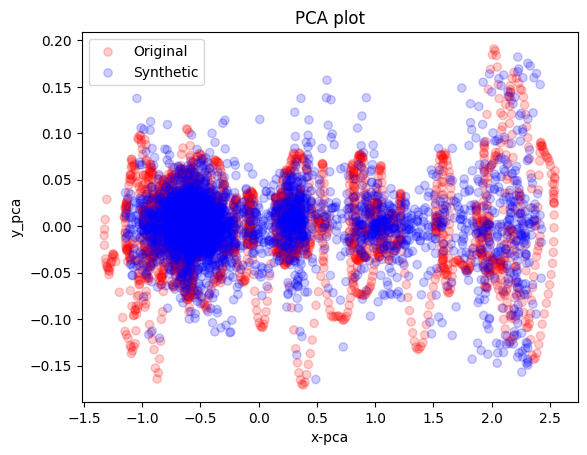

In [ ]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

In [ ]:
#Single metric computation
from Utils.compute_metrics import compute_metrics
metrics_1 = compute_metrics(ori_data, fake_data)

training discriminator:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
#Iterative metric computation for all fake_samples
from Utils.compute_metrics import compute_metrics

metrics_dict = {}

for i, fake_data in enumerate(fake_samples):
    print(f"Computing FID Score for fake_sample_{i}")
    metrics_dict[f"metrics_{i}"] = compute_metrics(ori_data, fake_data)

In [ ]:
import numpy as np
#Pearson's correlation coefficient
def calc_correlation(actual, predic):
    if actual.shape[0] > predic.shape[0]:
        actual = actual[:predic.shape[0]]
    elif predic.shape[0] > actual.shape[0]:
        predic = predic[:actual.shape[0]]

    a_mean = np.mean(actual, axis=1, keepdims=True)
    p_mean = np.mean(predic, axis=1, keepdims=True)

    a_diff = actual - a_mean
    p_diff = predic - p_mean

    numerator = np.sum(a_diff * p_diff, axis=1)
    denominator = np.sqrt(np.sum(a_diff ** 2, axis=1)) * np.sqrt(np.sum(p_diff ** 2, axis=1))
    correlation = numerator / (denominator + 1e-8)

    return abs(np.mean(correlation))

In [ ]:
for sample in fake_samples:
  cl = calc_correlation(ori_data,sample)
  print(cl)

0.012091459302788802
0.012748317750177212
0.019050644446265707
0.01870925295227746
0.016721266669534135
0.022548339091487717
0.006737369439015242
